# Time Series Prediction Example

Time series prediction is an interesting topic.  Everything from predicting electricity usage, sunspots to changes in equity prices can benefit from robust prediction methods.  In this article, I utilize Scikit-Learn and the Random Forest regression method

We use Yahoo finance to import the following equity data:
1. <b>UVXY</b> (this is the timeseries that we will be trying to predict)

First, lets do a little bit of setup.  We import the necessary libraries and get our data structures initialized.

Major Libraries Used:
* Pandas
* MatPlotLib
* Scikit-Learn    --  Random Forest Ensemble

In [30]:
%matplotlib inline
import pandas as pd
import datetime
from pandas.io import data, wb
import matplotlib.pyplot as plt
import time

# import Random Forest Regressor from sklearn
from sklearn.ensemble import RandomForestRegressor
import numpy as np
global ts

start_date='2016-01-01'
end_date='2016-07-27'

symbols = ['UVXY']
ts = data.DataReader(symbols, "yahoo", start_date, end_date)
uvxy_df = ts.swapaxes('items', 'minor').UVXY

### Lets look at the raw price data

We create a new DataFrame to hold the data, as well as the calculated Delta. We also print the last few entries of the timeseries UVXY to ensure everything has been set up properly.

                 Open       High        Low      Close      Volume  Adj Close
Date                                                                         
2016-07-21   6.120000   6.570000   6.020000   6.410000  11509400.0  32.050000
2016-07-22   6.320000   6.420000   5.970000   6.100000  43777300.0  30.500000
2016-07-25  30.049999  32.430000  29.629999  30.200001  20725400.0  30.200001
2016-07-26  30.200001  31.330000  29.549999  29.629999  21639000.0  29.629999
2016-07-27  28.750000  30.459999  27.700001  28.250000  25730500.0  28.250000


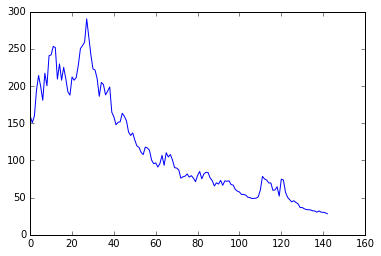

In [31]:
print(uvxy_df.tail())
plt.plot(uvxy_df['Adj Close'].values,'-b',label='data')
plt.show()

### Utilize Adjusted prices and take Pct Change (Mean Reverting)
Prices of equities can split (or reverse split) over time causing disruption in the underlying timeseries.  This is something we do not want, so we will be utilizing adjusted prices.

                 Open       High        Low      Close      Volume  Adj Close  \
Date                                                                            
2016-07-21   6.120000   6.570000   6.020000   6.410000  11509400.0  32.050000   
2016-07-22   6.320000   6.420000   5.970000   6.100000  43777300.0  30.500000   
2016-07-25  30.049999  32.430000  29.629999  30.200001  20725400.0  30.200001   
2016-07-26  30.200001  31.330000  29.549999  29.629999  21639000.0  29.629999   
2016-07-27  28.750000  30.459999  27.700001  28.250000  25730500.0  28.250000   

            Pct Change  Direction  
Date                               
2016-07-21    5.427632        1.0  
2016-07-22   -4.836193       -1.0  
2016-07-25   -0.983603       -1.0  
2016-07-26   -1.887424       -1.0  
2016-07-27   -4.657439       -1.0  


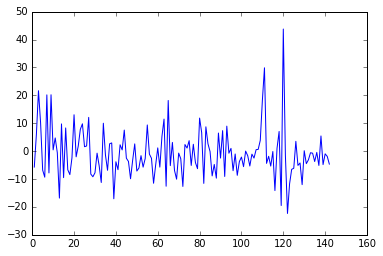

In [32]:
# Obtain ratio between close & adjusted closeyao    
closeratio = uvxy_df['Adj Close']/uvxy_df['Close']
uvxy_df['Pct Change'] = uvxy_df['Adj Close'].pct_change()*100
uvxy_df['Direction'] = np.sign(uvxy_df['Pct Change'])

print(uvxy_df.tail())
plt.plot(uvxy_df['Pct Change'].values,'-b',label='data')
plt.show()

## Define the input size to the model (lagged inputs) and model size.

In [33]:
testSize = 25  # Size of the data we want to fit
inputSize = 4  # number of lagged inputs to create

uvxy_df.dropna(how='any',inplace=True)
def create_lagged_series(today=False,today_close=0):
    if (today):
        df = uvxy_df[['Pct Change']].iloc[1:]
        lastclose = uvxy_df['Adj Close'][-1:].values[0]
        newchange = (today_close-lastclose)/lastclose*100
        df.loc[df.index.max() + datetime.timedelta(days=1)] = newchange
    else:
        df = uvxy_df[['Pct Change']].iloc[1:]

    for x in range(0,inputSize):
        df["Lag%s_Change" % str(x+1)] = df['Pct Change'].shift(x+1)
        
    df = df[inputSize:]
    return df

X = create_lagged_series(False)
y = uvxy_df['Pct Change'].iloc[1+inputSize:]
print(X.tail())
print("");
print(y.tail())
print(X.shape)
print(y.shape)

            Pct Change  Lag1_Change  Lag2_Change  Lag3_Change  Lag4_Change
Date                                                                      
2016-07-21    5.427632    -5.148206    -0.465842    -3.736921    -0.741840
2016-07-22   -4.836193     5.427632    -5.148206    -0.465842    -3.736921
2016-07-25   -0.983603    -4.836193     5.427632    -5.148206    -0.465842
2016-07-26   -1.887424    -0.983603    -4.836193     5.427632    -5.148206
2016-07-27   -4.657439    -1.887424    -0.983603    -4.836193     5.427632

Date
2016-07-21    5.427632
2016-07-22   -4.836193
2016-07-25   -0.983603
2016-07-26   -1.887424
2016-07-27   -4.657439
Name: Pct Change, dtype: float64
(137, 5)
(137,)


Directional Accuracy: 100.0%
[  7.34518824e+00  -1.59923331e+01   2.27859216e+01  -1.58824059e+00
  -1.59249023e+01  -1.15628709e+01  -6.67192980e+00  -6.03192487e+00
   3.83548894e+00  -5.23234122e+00  -4.08876706e+00  -1.18954050e+01
   1.01780300e-02  -4.41380924e+00  -3.15196861e+00  -6.99795489e-01
  -7.59408996e-01  -3.72077281e+00  -6.96685703e-01  -5.21696276e+00
   5.33435052e+00  -4.98625503e+00  -1.02151573e+00  -1.88901816e+00
  -4.83440734e+00]


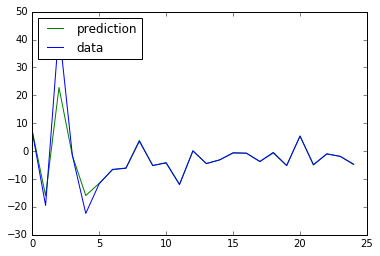

In [34]:
# Fit regression model
rng = np.random.RandomState(1)
rff = RandomForestRegressor(n_estimators=400, n_jobs=-1)

rff.fit(X[:-testSize],y[:-testSize])
rff_prediction = rff.predict(X[-testSize:])


rffcount = 0
for i in range(0,testSize):
    if ( ((rff_prediction[i] < 0) and (y[-testSize:].values[i] < 0)) or ((rff_prediction[i] >= 0) and (y[-testSize:].values[i] >= 0)) ):
        rffcount = rffcount + 1

# print ("rff: " + str(rffcount/testSize*100.0))
confidence = 0

plt.plot(rff_prediction[-testSize:],'-g',label='prediction')
confidence = rffcount/testSize*100.0
print("Directional Accuracy: " + str(confidence) + "%")
print(rff_prediction[-testSize:])
    
plt.plot(y[-testSize:].values,'-b',label='data')
plt.legend(loc='upper left')
plt.show()

In [35]:
todayclose = uvxy_df['Adj Close'].values[-1:][0]

print("Today's Close: $" + str(todayclose))
    
print("\n")
print("Today's Predicted Change (Accuracy: "+str(confidence)+"): ")

tomorrow = rff.predict(create_lagged_series(True,todayclose))

rff.fit(X,y)
tomorrow = rff.predict(create_lagged_series(True,todayclose))
print("[Predicted Change] -> "+ str(tomorrow[0]) + "%")
print(create_lagged_series(True,todayclose).tail())

tomorrow_close = todayclose + (todayclose * tomorrow[0]/100.0)
print("\nTomorrow Predicted Close: $" + str(tomorrow_close) )

Today's Close: $28.25


Today's Predicted Change (Accuracy: 100.0): 
[Predicted Change] -> -9.35095663328%
            Pct Change  Lag1_Change  Lag2_Change  Lag3_Change  Lag4_Change
2016-07-22   -4.836193     5.427632    -5.148206    -0.465842    -3.736921
2016-07-25   -0.983603    -4.836193     5.427632    -5.148206    -0.465842
2016-07-26   -1.887424    -0.983603    -4.836193     5.427632    -5.148206
2016-07-27   -4.657439    -1.887424    -0.983603    -4.836193     5.427632
2016-07-28    0.000000    -4.657439    -1.887424    -0.983603    -4.836193

Tomorrow Predicted Close: $25.6083547511
